In [2]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)
import os

## Fetch the jet tagging dataset from Open ML

In [3]:
data = fetch_openml('hls4ml_lhc_jets_hlf')
X, y = data['data'], data['target']

### Let's print some information about the dataset
Print the feature names and the dataset shape

In [4]:
print(data['feature_names'])
print(X.shape, y.shape)
print(X[:5])
print(y[:5])

['zlogz', 'c1_b0_mmdt', 'c1_b1_mmdt', 'c1_b2_mmdt', 'c2_b1_mmdt', 'c2_b2_mmdt', 'd2_b1_mmdt', 'd2_b2_mmdt', 'd2_a1_b1_mmdt', 'd2_a1_b2_mmdt', 'm2_b1_mmdt', 'm2_b2_mmdt', 'n2_b1_mmdt', 'n2_b2_mmdt', 'mass_mmdt', 'multiplicity']
(830000, 16) (830000,)
      zlogz  c1_b0_mmdt  c1_b1_mmdt  c1_b2_mmdt  c2_b1_mmdt  c2_b2_mmdt  \
0 -2.935125    0.383155    0.005126    0.000084    0.009070    0.000179   
1 -1.927335    0.270699    0.001585    0.000011    0.003232    0.000029   
2 -3.112147    0.458171    0.097914    0.028588    0.124278    0.038487   
3 -2.666515    0.437068    0.049122    0.007978    0.047477    0.004802   
4 -2.484843    0.428981    0.041786    0.006110    0.023066    0.001123   

   d2_b1_mmdt  d2_b2_mmdt  d2_a1_b1_mmdt  d2_a1_b2_mmdt  m2_b1_mmdt  \
0    1.769445    2.123898       1.769445       0.308185    0.135687   
1    2.038834    2.563099       2.038834       0.211886    0.063729   
2    1.269254    1.346238       1.269254       0.246488    0.115636   
3    0.966505  

As you saw above, the y target is an array of strings, e.g. ['g', 'w',...] etc. We need to make this a "One Hot" encoding for the training. Then, split the dataset into training and validation sets

In [5]:
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y, 5)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(y[:5])

[[1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]]


In [6]:
scaler = StandardScaler()
X_train_val = scaler.fit_transform(X_train_val)
X_test = scaler.transform(X_test)

In [7]:
np.save('X_train_val.npy', X_train_val)
np.save('X_test.npy', X_test)
np.save('y_train_val.npy', y_train_val)
np.save('y_test.npy', y_test)
np.save('classes.npy', le.classes_)

## Now construct a model
We'll use 3 hidden layers with 64, then 32, then 32 neurons. Each layer will use `relu` activation.
Add an output layer with 5 neurons (one for each class), then finish with Softmax activation.

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks

In [10]:
model = Sequential()
model.add(Dense(64, input_shape=(16,), name='fc1', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu1'))
model.add(Dense(32, name='fc2', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu2'))
model.add(Dense(32, name='fc3', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu3'))
model.add(Dense(5, name='output', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='softmax', name='softmax'))

## Train the model
We'll use Adam optimizer with categorical crossentropy loss.
The callbacks will decay the learning rate and save the model into a directory 'model_1'
The model isn't very complex, so this should just take a few minutes even on the CPU.
If you've restarted the notebook kernel after training once, set `train = False` to load the trained model.

In [12]:
train = True
if train:
    adam = Adam(lr=0.0001)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(stop_patience = 1000,
                              lr_factor = 0.5,
                              lr_patience = 10,
                              lr_epsilon = 0.000001,
                              lr_cooldown = 2,
                              lr_minimum = 0.0000001,
                              outputDir = 'model_1')
    model.fit(X_train_val, y_train_val, batch_size=1024,
              epochs=30, validation_split=0.25, shuffle=True,
              callbacks = callbacks.callbacks)
else:
    from tensorflow.keras.models import load_model
    model = load_model('model_1/KERAS_check_best_model.h5')

Epoch 1/30
  1/487 [..............................] - ETA: 0s - loss: 1.6388 - accuracy: 0.3027WARNING:tensorflow:From /home/elham/miniconda3/envs/hls4ml-tutorial/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
487/487 [==============================] - ETA: 0s - loss: 1.3290 - accuracy: 0.5161
***callbacks***
saving losses to model_1/losses.log

Epoch 00001: val_loss improved from inf to 1.12516, saving model to model_1/KERAS_check_best_model.h5

Epoch 00001: val_loss improved from inf to 1.12516, saving model to model_1/KERAS_check_best_model_weights.h5

Epoch 00001: saving model to model_1/KERAS_check_model_last.h5

Epoch 00001: saving model to model_1/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 3s 5ms/step - loss: 1.3290 - accuracy: 0.5

484/487 [============================>.] - ETA: 0s - loss: 0.8023 - accuracy: 0.7398
***callbacks***
saving losses to model_1/losses.log

Epoch 00012: val_loss improved from 0.80991 to 0.80382, saving model to model_1/KERAS_check_best_model.h5

Epoch 00012: val_loss improved from 0.80991 to 0.80382, saving model to model_1/KERAS_check_best_model_weights.h5

Epoch 00012: saving model to model_1/KERAS_check_model_last.h5

Epoch 00012: saving model to model_1/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 2s 5ms/step - loss: 0.8022 - accuracy: 0.7398 - val_loss: 0.8038 - val_accuracy: 0.7401
Epoch 13/30
482/487 [============================>.] - ETA: 0s - loss: 0.7967 - accuracy: 0.7413
***callbacks***
saving losses to model_1/losses.log

Epoch 00013: val_loss improved from 0.80382 to 0.79871, saving model to model_1/KERAS_check_best_model.h5

Epoch 00013: val_loss improved from 0.80382 to 0.79871, saving model to model_1/KERAS_check_bes

Epoch 25/30
484/487 [============================>.] - ETA: 0s - loss: 0.7636 - accuracy: 0.7505
***callbacks***
saving losses to model_1/losses.log

Epoch 00025: val_loss improved from 0.76958 to 0.76793, saving model to model_1/KERAS_check_best_model.h5

Epoch 00025: val_loss improved from 0.76958 to 0.76793, saving model to model_1/KERAS_check_best_model_weights.h5

Epoch 00025: saving model to model_1/KERAS_check_model_last.h5

Epoch 00025: saving model to model_1/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 2s 5ms/step - loss: 0.7635 - accuracy: 0.7505 - val_loss: 0.7679 - val_accuracy: 0.7493
Epoch 26/30
486/487 [============================>.] - ETA: 0s - loss: 0.7619 - accuracy: 0.7509
***callbacks***
saving losses to model_1/losses.log

Epoch 00026: val_loss improved from 0.76793 to 0.76634, saving model to model_1/KERAS_check_best_model.h5

Epoch 00026: val_loss improved from 0.76793 to 0.76634, saving model to model_1/KER

## Check performance
Check the accuracy and make a ROC curve

Accuracy: 0.7502650602409638


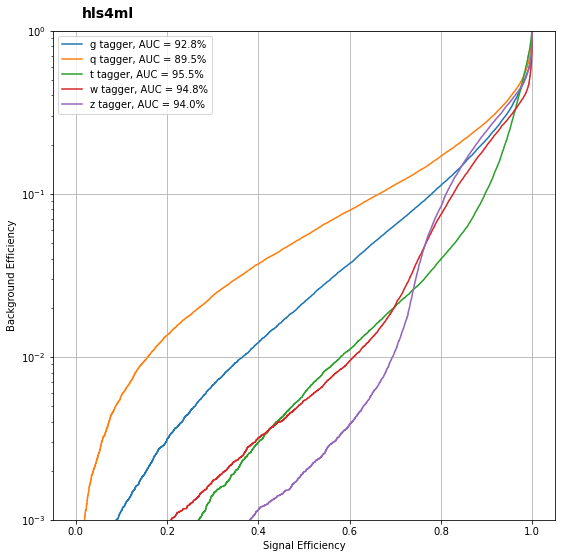

In [15]:
import plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
y_keras = model.predict(X_test)
print("Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
plt.figure(figsize=(9,9))
_ = plotting.makeRoc(y_test, y_keras, le.classes_)